# Introduction to SageMaker Jumpstart Built-In Algorithms - Text Embedding
> *This notebook should work well with the **`Data Science 2.0`** kernel in SageMaker Studio*

---
Welcome to Amazon [SageMaker Jumpstart Built-In Algorithms](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-jumpstart.html)! You can use Sagemaker Built-In Algorithms to solve many Machine Learning tasks through one-click in SageMaker Studio, or through [SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/overview.html#use-prebuilt-models-with-sagemaker-jumpstart).

In this demo notebook, we demonstrate how to use the SageMaker Python SDK for Text Embedding. Text Embedding is the task of converting text into meaningful vector representations. We show how to use pre-trained model to find text embeddings. Additionally, we also show how to leverage these embeddings for Semantic Textual Similarity.

---

1. [Set Up](#1.-Set-Up)
2. [Select a model](#2.-Select-a-model)
3. [Retrieve Artifacts & Deploy an Endpoint](#3.-Retrieve-Artifacts-&-Deploy-an-Endpoint)
4. [Query endpoint and parse response](#4.-Query-endpoint-and-parse-response)
5. [Semantic Textual Similarity](#5.-Semantic-Textual-Similarity)

In [1]:
!pip install sagemaker --quiet --upgrade --force-reinstall
!pip install ipywidgets==7.0.0 

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.
spyder 5.1.5 requires pyqt5<5.13, which is not installed.
spyder 5.1.5 requires pyqtwebengine<5.13, which is not installed.
autovizwidget 0.21.0 requires pandas<2.0.0,>=0.20.1, but you have pandas 2.0.3 which is incompatible.
awscli 1.29.63 requires botocore==1.31.63, but you have botocore 1.32.3 which is incompatible.
flask 3.0.0 requires Werkzeug>=3.0.0, but you have werkzeug 2.3.7 which is incompatible.
hd

In [3]:
import sagemaker, boto3, json
from sagemaker.session import Session

sagemaker_session = Session()
aws_role = sagemaker_session.get_caller_identity_arn()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


Show all the Text Embedding Models available to deploy using SageMaker SDK

In [4]:
from sagemaker.jumpstart.notebook_utils import list_jumpstart_models

# filter_value = "task == tcembedding"
filter_value = "task == textembedding"
# huggingface-textembedding-gpt-j-6b-fp16
text_embedding_models = list_jumpstart_models(filter=filter_value)
# text_embedding_models = list_jumpstart_models()

In [5]:
text_embedding_models

['huggingface-textembedding-all-MiniLM-L6-v2',
 'huggingface-textembedding-bloom-7b1',
 'huggingface-textembedding-bloom-7b1-fp16',
 'huggingface-textembedding-gpt-j-6b',
 'huggingface-textembedding-gpt-j-6b-fp16']

# What is Vector Embedding
## Introduction
Vector embeddings are essential components in solving various NLP tasks. It's widely adopted for addressing challenges in providing recommendation, search algorithms and more. 

In a nutshell, a vector embedding is a numeric representation of an object. These objects could be texts, images, audios or videos. Because they are numerical, we could perform various operations with them. For instance, a whole paragraph of text or any other object can be reduced to a vector. Even numerical data can be turned into vectors for easier operations.

The importance of vector embeddings for LLMs extends beyond language generation. These embeddings also facilitate a range of downstream tasks, such as sentiment analysis, named entity recognition, text classification, and more. By incorporating pre-trained vector embeddings, LLMs can leverage the knowledge captured during the embedding training process, leading to improved performance on these tasks.

![Vector Embeddings](images/vector-embeddings.png)

## Embedding Model Selection
There are many embedding models to choose from, ranging from the proprietary models, to open source models. Choosing the right embeddings is an essential step in the development of an LLM application. 
While important, evaluating the performance of all embedding models is extremely time consuming, in many cases not feasible due to time and hardware resouces required to perform these evaluations. For this, we turn to open source comminity for insights. Hugging Face, a renowned platform in the NLP community hosts the Massive Text Embedding Benchmark (MTEB) Leaderboard. This leaderboard serves as a valuable resource for evaluating the performance of various text embedding models across diverse embedding tasks. For a comprehensive understanding of the MTEB Leaderboard and its significance, I recommend referring to the “MTEB: Massive Text Embedding Benchmark” available at (https://huggingface.co/spaces/mteb). It provides a thorough explanation of the leaderboard’s purpose and insights into different text embedding models. Exploring this resource will broaden your understanding of the text embedding landscape and assist you in making informed decisions for your embedding needs.

In this notebook, we'll explore an embedding model supported in SageMaker Jumpstart. 

In [6]:
model_id, model_version = "huggingface-textembedding-gpt-j-6b-fp16", "*"

### 3. Retrieve Artifacts & Deploy an Endpoint

***

We start by retrieving the `deploy_image_uri`, `deploy_source_uri`, and `model_uri` for the pre-trained model. To host the pre-trained model, we create an instance of [`sagemaker.model.Model`](https://sagemaker.readthedocs.io/en/stable/api/inference/model.html) and deploy it. This may take a few minutes.
***


In [7]:
from sagemaker import image_uris, model_uris, script_uris, hyperparameters
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.utils import name_from_base

from sagemaker.jumpstart.model import JumpStartModel

my_model = JumpStartModel(model_id=model_id)
predictor = my_model.deploy() 

-------------!

In [12]:
print(f"Embedding endpoint name: {predictor.endpoint_name}")

Embedding endpoint name: hf-textembedding-gpt-j-6b-fp16-2023-11-18-17-32-19-920


In [13]:
def query(model_predictor, text):
    """Query the model predictor."""

    encoded_text = text.encode("utf-8")

    query_response = model_predictor.predict(
        encoded_text,
        {
            "ContentType": "application/x-text",
            "Accept": "application/json",
        },
    )
    return query_response


def parse_response(query_response):
    """Parse response and return the embedding."""

    if isinstance(query_response, dict):
        model_predictions = query_response
    else:
        model_predictions = json.loads(query_response)
    
    translation_text = model_predictions["embedding"]
    return translation_text

In [14]:
predictor.serializer = sagemaker.base_serializers.IdentitySerializer()
predictor.deserializer = sagemaker.base_deserializers.BytesDeserializer()
embedding_endpoint_name = predictor.endpoint_name

In [15]:
newline, bold, unbold = "\n", "\033[1m", "\033[0m"

input_text = "astonishing ... ( frames ) profound ethical and philosophical questions in the form of dazzling pop entertainment"


query_response = query(predictor, input_text)
embedding = parse_response(query_response)

print(
    f"{bold}Inference{unbold}:{newline}"
    f"{bold}Input text sentence{unbold}: '{input_text}'{newline}"
    f"{bold}The first 5 elements of sentence embedding{unbold}: {embedding[:5]}{newline}"
    f"{bold}Sentence embedding size{unbold}: {len(embedding)}{newline}"
)

Inference:
Input text sentence: 'astonishing ... ( frames ) profound ethical and philosophical questions in the form of dazzling pop entertainment'
The first 5 elements of sentence embedding: [[0.009996350854635239, -0.02590801566839218, 0.0035119703970849514, 0.007944339886307716, 0.009689831174910069, 0.033790651708841324, -0.004627589136362076, 0.0006076921708881855, 0.011857078410685062, 0.0003446016926318407, 0.002330269431695342, 0.01107209175825119, 0.0007209235336631536, 0.001853365683928132, -0.0011050882749259472, -0.004702294245362282, 0.01713818870484829, -0.012639057822525501, 0.012963414192199707, -0.012942683883011341, 0.0010387217625975609, -0.0017110742628574371, 0.006888621021062136, -0.008405650034546852, 0.009511508978903294, -0.011742526665329933, -0.0022953753359615803, -0.0040961061604321, 0.02139236405491829, -0.0013950372813269496, -0.01219457108527422, 0.0038425284437835217, -0.007446082308888435, 0.005350677762180567, 0.008284089155495167, 0.00611214572563767

### 4. Semantic Similarity

A use case of sentence embedding is to cluster together sentences with similar semantic meaning.  In the example below we compute the embeddings of sentences in three categories: pets, cities in the U.S., and color.  We see that sentences originating from the same category have much closer embedding vectors than those from different categories.  Specifically, the code will do the following:
The SageMaker embedding model will output an embedding vector for each sentence;  The distance between any pair of sentences is computed by the cosine similarity of corresponded embedding vectors;A heatmap is created to visualize the distance between any pair of sentences in the embedding space. Darker the color, larger the cosine similarity (smaller the distance).
Note. Cosine similarity of two vectors is  the inner product of the normalized vectors (scale down to have length 1).

In [16]:
%matplotlib inline

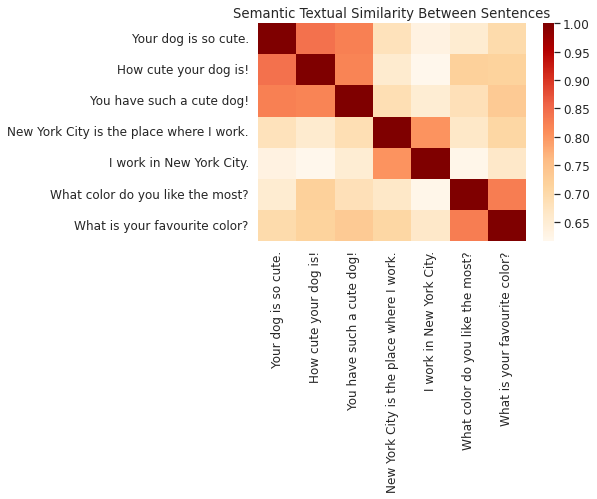

In [17]:
import sklearn
from sklearn.preprocessing import normalize
import numpy as np
import seaborn as sns


def get_embedding(predictor, sentence):
    query_response = query(predictor, sentence)
    embedding = parse_response(query_response)
    return embedding
    
def plot_similarity_heatmap(text_labels, embeddings, rotation):
    """Takes sentences, embeddings and rotation as input and plot similarity heat map.

    Args:
      text_labels: a list of sentences to compute semantic textual similarity search.
      embeddings: a list of embedding vectors, each of which corresponds to a sentence.
      rotation: rotation used for display of the text_labels.
    """
    inner_product = np.inner(embeddings, embeddings)
    sns.set(font_scale=1.1)
    graph = sns.heatmap(
        inner_product,
        xticklabels=text_labels,
        yticklabels=text_labels,
        vmin=np.min(inner_product),
        vmax=1,
        cmap="OrRd",
    )
    graph.set_xticklabels(text_labels, rotation=rotation)
    graph.set_title("Semantic Textual Similarity Between Sentences")


sentences = [
    # Pets
    "Your dog is so cute.",
    "How cute your dog is!",
    "You have such a cute dog!",
    # Cities in the US
    "New York City is the place where I work.",
    "I work in New York City.",
    # Color
    "What color do you like the most?",
    "What is your favourite color?",
]

embeddings = []

for sentence in sentences:
    query_response = get_embedding(predictor=predictor, sentence=sentence)
    embeddings.append(query_response[0])
    
embeddings = normalize(np.array(embeddings), axis=1)  # normalization before inner product
plot_similarity_heatmap(sentences, embeddings, 90)

In [18]:
%store embedding_endpoint_name

Stored 'embedding_endpoint_name' (str)


### Next Step

In the next lab, we'll develop a knowledge base repository using a vector database that can be used to provide semantic search capability for downstream tasks, including a Q&A bot. We'll use the embedding model to extract the embeddings from the given documents and ingest into the vector database. Additionally, we'll use the embedding model to find similar documents from the vector database to build a RAG based chatbot application.